In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
# df.head()

In [ ]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
df_test.head()

In [ ]:
df.info()

In [ ]:
df.describe().round(1)

In [ ]:
df.isna().sum()

In [ ]:
sns.heatmap(df.isna().sort_values(by=["Occupation"]) == True)

In [5]:
# df.dropna(inplace = True)
for non_object_column in df.select_dtypes(exclude = "object").columns:
    df[non_object_column].fillna(df[non_object_column].mean(), inplace = True)

df.dropna(inplace = True)

In [ ]:
df.shape

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot = True, cmap = "Reds")

In [ ]:
df_categorical = df.select_dtypes('object')
for object_column in df_categorical.columns:
    print(object_column, {df[object_column].nunique()}, ': ', df[object_column].unique(), '\n')

In [6]:
df.drop(['id', 'Policy Start Date'], axis = 1, inplace = True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'Premium Amount':
        df[non_object_column] = df[non_object_column] / df[non_object_column].max()

In [ ]:
df.head()

In [ ]:
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"].apply(lambda x: x[:10]))

In [ ]:
pd.get_dummies(df_categorical, drop_first = True, dtype = int)

In [7]:
df = pd.concat(
    [
        df.select_dtypes(exclude = "object"), 
        pd.get_dummies(df.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)
df.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.00000,5.0,2869.0,0,...,0,1,0,1,0,0,0,1,0,1
2,23.0,25602.0,3.0,47.177549,1.0,14.0,592.92435,3.0,567.0,1,...,0,1,1,0,1,0,0,1,0,1
4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.00000,4.0,2022.0,1,...,0,1,0,1,1,0,0,1,0,1
7,48.0,127237.0,2.0,5.769783,1.0,11.0,398.00000,5.0,111.0,0,...,1,0,0,0,0,0,1,0,1,0
9,44.0,52447.0,2.0,20.473718,1.0,9.0,635.00000,3.0,64.0,1,...,1,0,0,1,0,0,0,0,1,0


In [8]:
df.to_csv("train_new.csv", index=False)

In [97]:
df = pd.read_csv("/kaggle/working/train_new.csv")

In [ ]:
df.dtypes

In [ ]:
df.describe()

In [ ]:
plt.boxplot(df['Premium Amount'])

In [ ]:
plt.boxplot(df['Annual Income'])

In [ ]:
plt.boxplot(df['Previous Claims'])

In [ ]:
df[df['Previous Claims'] > 2]['Age'].count()

In [ ]:
df[df['Annual Income'] > 100_000]['Age'].count()

In [ ]:
df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3000)]['Age'].count()

In [ ]:
df['Age'].count()

In [9]:
df2 = df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3_000)]
df2['Age'].count()

105085

In [10]:
df = df[(df['Previous Claims'] <= 2) & (df['Annual Income'] <= 100_000) & (df['Premium Amount'] <= 3000)]
df['Age'].count()

670189

In [98]:
x = df.drop(['Premium Amount'], axis = 1)
y = df['Premium Amount']

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [100]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=28, random_state=0)
model3 = PolynomialFeatures(degree=4)
model4 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 14,
                            n_estimators = 1000,
                            verbose = False
)
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 14,
                            n_estimators = 1000,
                            verbose = False
)

In [ ]:
x_train = model3.fit_transform(x_train)
x_test = model3.fit_transform(x_test)
x = model3.fit_transform(x)

In [101]:
# model = model3
# model.fit(model3.fit_transform(x_train))

# model = model1
# model.fit(model3.fit(model3.fit_transform(x_train)), y_train)

model = model4
model.fit(x_train, y_train)

In [102]:
y_pred = model.predict(x_test)

In [103]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

In [104]:
df_pred = pd.DataFrame([y_pred, y_test]).transpose()
df_pred = df_pred.describe()
df_pred['diff'] = df_pred[0] - df_pred[1]
df_pred['0/1'] = df_pred[0] / df_pred[1]
df_pred

,0,1,diff,0/1
count,155055.000000,155055.000000,0.000000,1.000000
mean,1098.187639,1099.595872,-1.408234,0.998719
std,184.797266,868.249656,-683.452390,0.212839
min,269.487170,20.000000,249.487170,13.474358
25%,1048.701596,509.000000,539.701596,2.060317
50%,1089.802086,861.000000,228.802086,1.265740
75%,1155.303378,1504.000000,-348.696622,0.768154
max,1897.786185,4988.000000,-3090.213815,0.380470


<ipython-input-52-57f1de8a0ccb>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


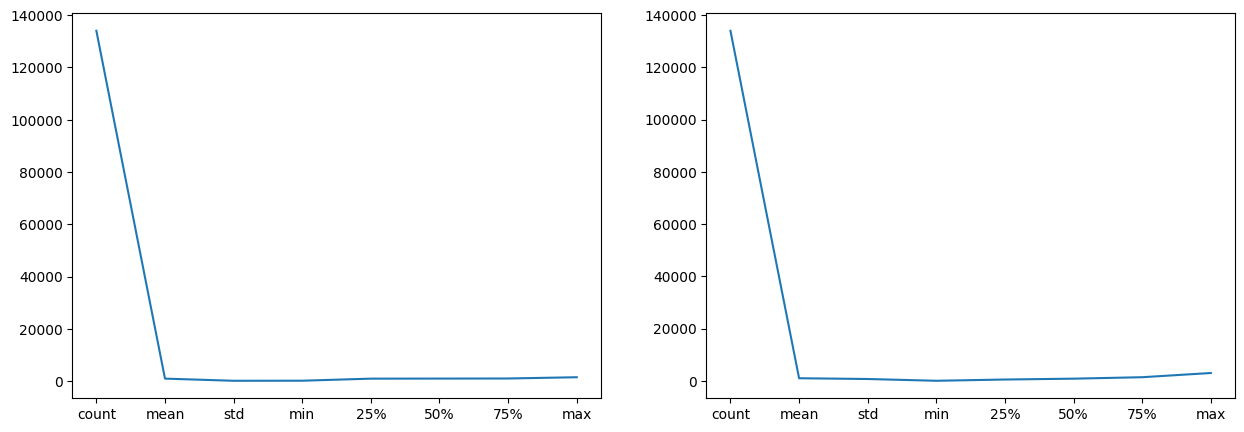

In [52]:
fig, ax = plt.subplots(figsize=(15, 5), sharey=True)
plt.subplot(1, 2, 1)
plt.plot(df_pred[0][:1000])
plt.subplot(1, 2, 2)
plt.plot(df_pred[1][:1000])

In [105]:
rmsle(y_pred, y_test)

1.139441954296408

In [115]:
rmsle(y_pred-270, y_test)

1.072067732207212

In [116]:
model.fit(x, y)

In [121]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

# for non_object_column in df_test.select_dtypes(exclude = "object").columns:
#     df_test[non_object_column] = df_test[non_object_column] / df_test[non_object_column].max()

for non_object_column in df_test.select_dtypes(exclude = "object").columns:
    df_test[non_object_column].fillna(df_test[non_object_column].mean(), inplace = True)

df_test["Policy Start Date"] = pd.to_datetime(df_test["Policy Start Date"].apply(lambda x: x[:10]))

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"), 
        pd.get_dummies(df_test.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)

x_df_test = df_test.drop(['id', 'Policy Start Date'], axis = 1)

x2_df_test = x_df_test[(x_df_test['Previous Claims'] > 2) | (x_df_test['Annual Income'] > 100_000)]

# x_df_test = x_df_test[(x_df_test['Previous Claims'] <= 2) & (x_df_test['Annual Income'] <= 100_000)]

print(x_df_test.shape)
print(x2_df_test.shape)
x_df_test.head()

(800000, 28)
(82513, 28)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Married,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,28.0,2310.0,4.0,7.657981,1.004873,19.0,592.904749,1.0,0,0,...,0,0,0,1,1,0,0,1,0,1
1,31.0,126031.0,2.0,13.381379,1.004873,14.0,372.000000,8.0,0,1,...,0,1,1,0,1,0,1,0,0,0
2,47.0,17092.0,0.0,24.354527,1.004873,16.0,819.000000,9.0,0,0,...,1,0,0,0,1,1,0,0,1,0
3,28.0,30424.0,3.0,5.136225,1.000000,3.0,770.000000,5.0,0,0,...,1,0,0,1,1,0,0,0,0,1
4,24.0,10863.0,2.0,11.844155,1.004873,14.0,755.000000,7.0,1,0,...,0,1,0,0,0,0,0,1,0,1


In [ ]:
df_test[(df_test['Previous Claims'] > 2) | (df_test['Annual Income'] > 100_000)]['Age'].count()

In [117]:
Y_pred_test = model.predict(x_df_test)

In [23]:
x2 = df2.drop(['Premium Amount'], axis = 1)
y2 = df2['Premium Amount']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 1)
model_2 = model4_2
model_2.fit(x2_train, y2_train)
y2_pred = model_2.predict(x2_test)

df2_pred = pd.DataFrame([y2_pred, y2_test]).transpose()
df2_pred = df2_pred.describe()
df2_pred['diff'] = df2_pred[0] - df2_pred[1]
df2_pred['0/1'] = df2_pred[0] / df2_pred[1]
df2_pred

,0,1,diff,0/1
count,21017.000000,21017.000000,0.000000,1.000000
mean,1779.319952,1781.543132,-2.223180,0.998752
std,1058.247219,1367.978774,-309.731554,0.773585
min,432.339131,20.000000,412.339131,21.616957
25%,1131.859991,562.000000,569.859991,2.013986
50%,1210.682039,1394.000000,-183.317961,0.868495
75%,3461.736168,3128.000000,333.736168,1.106693
max,3848.262283,4988.000000,-1139.737717,0.771504


In [24]:
print(rmsle(y2_pred, y2_test))

1.1170254281235452


In [25]:
print(rmsle(y2_pred-401.5, y2_test))

1.0292567657828962


In [38]:
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 9,
                            n_estimators = 1000,
                            verbose = False
)
model_2 = model4_2
model_2.fit(x2, y2)

In [39]:
Y2_pred_test = model_2.predict(x2_df_test)

In [40]:
Y_pred_test.size + Y2_pred_test.size

800000

In [41]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
df_sub.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [118]:
Y_pred_test = Y_pred_test - 270

# Y2_pred_test = Y2_pred_test - 401.5

In [43]:
x_df_test['Prediction'] = Y_pred_test

x2_df_test['Prediction'] = Y2_pred_test

Y_pred_test_result = pd.concat([x_df_test, x2_df_test], axis = 'rows')['Prediction'].sort_index()

In [44]:
Y_pred_test_result.size

800000

In [119]:
df_test['Premium Amount'] = Y_pred_test.round(3)
df_submission = df_test[['id', 'Premium Amount']]

print(df_submission.shape)
df_submission.head()

(800000, 2)


,id,Premium Amount
0,1200000,1265.923
1,1200001,856.162
2,1200002,718.238
3,1200003,771.976
4,1200004,719.497


In [122]:
df_submission.to_csv("submissions.csv", index=False)

In [137]:
df = df.sort_values(by='Premium Amount').reset_index(drop=True)
df

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,48.0,16123.0,4.000000,42.146579,1.002689,6.0,426.0,1.0,20.0,0,...,0,0,0,0,0,0,1,0,0,1
1,27.0,5547.0,2.009934,23.827292,2.000000,0.0,836.0,2.0,20.0,0,...,1,0,0,0,1,0,0,1,0,0
2,58.0,70579.0,2.000000,45.530716,0.000000,6.0,468.0,4.0,20.0,1,...,1,0,0,0,0,1,0,0,0,0
3,34.0,44226.0,0.000000,7.180466,1.002689,13.0,553.0,5.0,20.0,0,...,0,0,0,1,1,0,1,0,0,1
4,43.0,26625.0,2.000000,25.613908,0.000000,2.0,456.0,5.0,20.0,0,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775269,48.0,2428.0,1.000000,40.988798,1.000000,11.0,696.0,5.0,4988.0,1,...,1,0,0,0,1,0,1,0,0,1
775270,52.0,23435.0,1.000000,13.285972,1.002689,15.0,340.0,8.0,4994.0,0,...,0,0,0,0,0,0,0,0,0,0
775271,62.0,8440.0,3.000000,21.997465,0.000000,1.0,581.0,5.0,4996.0,0,...,0,1,1,0,1,0,0,0,0,0
775272,26.0,79801.0,3.000000,19.739327,1.002689,5.0,571.0,3.0,4997.0,0,...,0,1,0,0,1,0,0,1,0,0


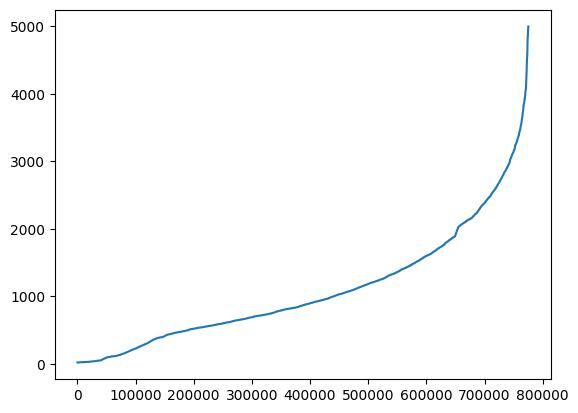

In [140]:
plt.plot(df['Premium Amount'])